<a href="https://colab.research.google.com/github/danwein8/Deep-Q-Network-Agents/blob/main/PendulumAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:4.2.7-0u

In [37]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [38]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [39]:
tf.version.VERSION

'2.12.0'

In [40]:
num_iterations = 45000 # @param {type:"integer"}

initial_collect_steps = 100 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 1000000 # @param {type:"integer"}

batch_size = 64 # @param {type:"integer"}
learning_rate = 1e-3 # @param {type:"number"}
log_interval = 200 # @param {type:"integer"}

num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 1000 # @param {type:"integer"}

Because we have a continuous action space consisting of floats between `[-2.0, 2.0]` we have to wrap the environment in an ActionDiscretizeWrapper to artificially make the action space discreet. We also specify the number of actions we want there to be, to represent that continuous actions space, I choose 5 here because there are 5 integers between -2 and 2, so the action space *should* consist of `[-2, -1, 0, 1, 2]` but I don't know how TF splits up the action space.

In [41]:
from tf_agents.environments import wrappers
env_name = 'Pendulum-v1'
env = suite_gym.load(env_name)
env = wrappers.ActionDiscretizeWrapper(env, num_actions=5)

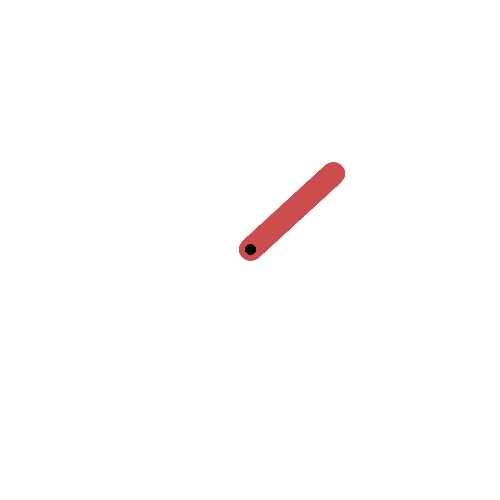

In [42]:
env.reset()
PIL.Image.fromarray(env.render())

In [43]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(3,), dtype=dtype('float32'), name='observation', minimum=[-1. -1. -8.], maximum=[1. 1. 8.])


In [44]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [45]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=4)


# Pendulum
In the Pendulum environment we have an observation array of 3 floats, these floats represent the coordinates of the pendulums free end and it's angular velocity.<br><br>
Our action space consists of `[-2, -1, 0, 1, 2]` (originally a continuous range between `[-2.0, 2.0]`) where these are the discrete actions of applying torque to the joint to turn the pendulum, I wont explain it here because it would take too long, instead there is a link to the documentation below.<br><br>
The goal is to keep the pendulum straight up vertically with zero velocity, also outlined in the documnentation<br><br>
https://gymnasium.farama.org/environments/classic_control/pendulum/

In [46]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.9935675 ,  0.11324111,  0.9049183 ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.9974455,  0.0714312,  0.8398492], dtype=float32),
 'reward': array(-9.252326, dtype=float32),
 'step_type': array(1, dtype=int32)})


The time steps have discounts, observations, rewards, and step types in them.
this is all the information about what is going on in the game.

In [47]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_py_env = wrappers.ActionDiscretizeWrapper(train_py_env, num_actions=5)
eval_py_env = wrappers.ActionDiscretizeWrapper(eval_py_env, num_actions=5)

The original game environments are written in pure python so we convert them to
TensorFlow using wrappers below to make running more efficient. This converts
NumPy arrays to Tensors to make things compatible. We also use the `ActionDiscretizeWrappers()` above again to make more environments discreet.

In [48]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

Here we create a DQN Agent because our environment has a discrete action space
meaning there are a finite amount of actions we can take. The DQN Agent uses
a QNetwork which is a neural network that learns weights to predict QValues,
the expected returns, for all actions given an observation (state) from the
environment. If we have the returns for all actions then we have our policy, 
meaning we know what actions to take in any state to get the highest reward 
return.

Our QNetwork will be made using tf_agents.networks, this will consist of a 
sequence of Dense layers where the final layer will have one output for each
possible action

In [49]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Now we instantiate a DQN agent with tf_agents.agents.dqn.dqn_agent(), the 
constructor requires a time_step_spec, action_spec, QNetwork, and an optimizer

In [50]:
print('Action Spec: ', env.action_spec())

Action Spec:  BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=4)


In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

The policy defines the way an agent acts in an environment, we want to train the
underlying model until the policy produces the desired outcome. We do this by
training the QNetwork, which is a neural network that is a part of our DQN
agent, the weights essentially are the policy, when the loss is low, our agents
actions are returning a high reward. Here our desired outcome is to get the 
acrobot arm above the black line. The policy is going to return an action (left torque, right torque, or noop) for each time_step, and each time step has observations about the environment that tell us whats happening, allowing us to build the policy.<br><br>

- agent.policy - main policy used for evaluation and deployment<br>
- agent.collect_policy - a second policy that is used for data collection

In [52]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

We can create random policies independently of agents, we will create a random
policy that takes a random action at each time step.

In [53]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy we call policy.action(time_step). the time_step
contains the observations from the environment that the policy needs to take
into account to make its decision, since our policy is untrained right now it
will probably be random. This method returns a PolicyStep which is a named tuple
with 3 components:<br>
- action - the action to be taken(-2, -1, 0, 1, 2, which is -1 torque (< 0), noop (0), or 1 torque (> 0)<br>
- state - used for stateful(RNN-based) policies<br>
- info - auxiliary data, such as log probabilities of actions

In [54]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('Pendulum-v1'))
example_environment = wrappers.ActionDiscretizeWrapper(example_environment, num_actions=5)

In [55]:
time_step = example_environment.reset()

In [56]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, state=(), info=())

#Metrics
The most common metric used ot evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run creating an average return. So instead of calculating a loss for the nerual network directly, I think we use a combination of the average return and the loss function to optimize the QNetwork and obtain the best policy.

In [57]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      # gets the action of the policy based on the time step observations
      action_step = policy.action(time_step)
      # takes an action in the environment, specifically the one we just found
      # in the last line of code based on the policy
      time_step = environment.step(action_step.action)
      # adds time step reward to the episode reward
      episode_return += time_step.reward
    # adds episode reward to the total reward
    total_return += episode_return

  # averages the total return over num of episodes
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics


Running this computation on the random policy gets us a baseline performance in the environment

In [58]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-1222.1542

In [59]:
compute_avg_return(eval_env, eval_policy, num_eval_episodes)

-1394.1699

The reward function is much more complicated in the `Pendulum` environment, <br>
r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2) <br>
so the rewards are based on that

In [60]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

#Trajectory Tuple<br>
The Trajectory tuple is a named tuple containing loads of useful information. If we look at the fields we have 7 items to look through. Actually reading the output of Trajectory we will try to see what info is given:<br>
- `action`: this is the first item in Trajectory. Since this is a discrete action space agent we have the entire range of actions as a minimum (-2) and maximum (2) represented as a `tf.int64`, it shows its just a scalar by the shape, and lastly it shows the name `'action'`.<br>
- `discount`: this represents the discount given to the rewards at each step. It is a scalar based on the shape, but its a `float32` value beteween 0.0 and 1.0 since we are using this to discount rewards we just need a multiplier essentially, it also holds the name `'observation'`.<br>
- `next_step_type`: this represents the next step to be taken, in this case will just be a scalar value from the discrete range -2, -1, 0, 1, 2. We do not know this value yet because the agent is not trained and does not have a policy to check the observations against to make this decision.<br>
- `observation`: this represents the environment observations needed to make a decision with the policy. In this case that is the position of the free end of the pendulum, and the angular velocity of the free end of the pendulum (based on the documentation). Surprisingly, if we look at the 2 arrays that are given, one is the minimum values and one is the maximum values, its not the case that there are 3 arrays to store each observation range. <br>
- `policy_info`: this represents the current policy, this is empty because the agent is untrained right now. As we train the agent, this should fill up with more and more info. <br>
- `reward`: this represents the current reward of the agent, it is a scalar value. You will notice it is a `float32`, it has to be that way because when the rewards are discounted they will become floats, then its a summation of floats which is a float. <br>
- `step_type`: this represents what the agent did for this step, so it will be a scalar value that is an `int32`, and even though it doesn't have a range, it can only be -2, -1, 0, 1, or 2 in this case because this is a discrete environment and a discrete agent.

In [61]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='observation', minimum=array([-1., -1., -8.], dtype=float32), maximum=array([1., 1., 8.], dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [62]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

Execute the random policy in the environment for a few steps, recording the data in the replay buffer. Here we use `PyDriver` to run the experience collecting loop.

In [63]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([-0.9961526 ,  0.08763586,  2.2313976 ], dtype=float32),
  'reward': array(-8.97885, dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [64]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 3], dtype=int32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-0.99949574,  0.03175246, -1.0976415 ],
        [-0.99495924,  0.10028031, -1.3738272 ]], dtype=float32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-9.795554, -9.438293], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([8511076546348654685, 8511076546348654685], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dt

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.<br><br>

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).<br><br>

This dataset is also optimized by running parallel calls and prefetching data.

In [65]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 3), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [66]:
iterator = iter(dataset)
print(iterator)

In [67]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

iterator.next()

(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=int32, numpy=
 array([[2, 4],
        [1, 3],
        [2, 0],
        [2, 2],
        [2, 1],
        [2, 4],
        [3, 2],
        [4, 0],
        [2, 4],
        [2, 0],
        [3, 0],
        [2, 3],
        [1, 1],
        [4, 4],
        [2, 1],
        [2, 3],
        [0, 0],
        [0, 4],
        [0, 4],
        [3, 1],
        [1, 0],
        [3, 2],
        [4, 4],
        [4, 2],
        [2, 1],
        [3, 3],
        [1, 0],
        [3, 1],
        [3, 1],
        [1, 3],
        [0, 0],
        [2, 0],
        [3, 3],
        [1, 2],
        [2, 0],
        [4, 0],
        [0, 0],
        [1, 3],
        [1, 0],
        [2, 0],
        [4, 3],
        [1, 2],
        [4, 2],
        [2, 1],
        [4, 3],
        [0, 4],
        [2, 3],
        [3, 2],
        [0, 2],
        [1, 3],
        [4, 0],
        [0, 0],
        [0, 3],
        [3, 3],
        [2, 1],
        [4, 4],
        [4, 4],
        [4, 4],


#Train the Agent<br>
2 things have to happen during the training loop:<br><br>
- collect data from the environment<br>
- use that data to train the agent's neural network(s)<br>
NOTE: The artificially descretized action space makes the problem much more complex calling for more than double the normal training to get similar results.

In [68]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  # Experience is the observations from Trajectory, unused_info is everything else
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  # Just an optional counter that is incremented each time the train operation
  # is run
  step = agent.train_step_counter.numpy()

  # if the train_step_counter is a multiple of log_interval hyperparam (200),
  # print some info
  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  # if the train_step_counter is a multiple of eval_interval hyperparam (1000),
  # print some info, calculate average return, append that calculation to the
  # returns array made earlier
  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 686.0304565429688
step = 400: loss = 952.2244873046875
step = 600: loss = 149.33895874023438
step = 800: loss = 185.750732421875
step = 1000: loss = 119.15829467773438
step = 1000: Average Return = -1021.2269287109375
step = 1200: loss = 253.88565063476562
step = 1400: loss = 6552.04541015625
step = 1600: loss = 4275.74169921875
step = 1800: loss = 303.0928955078125
step = 2000: loss = 955.5567626953125
step = 2000: Average Return = -1260.072509765625
step = 2200: loss = 1312.515869140625
step = 2400: loss = 190.50518798828125
step = 2600: loss = 102.30998229980469
step = 2800: loss = 238.92291259765625
step = 3000: loss = 172.244140625
step = 3000: Average Return = -1464.46435546875
step = 3200: loss = 645.513916015625
step = 3400: loss = 161.560302734375
step = 3600: loss = 143.28964233398438
step = 3800: loss = 156.00460815429688
step = 4000: loss = 119.27269744873047
step = 4000: Average Return = -1356.6702880859375
step = 4200: loss = 133.21922302246094
step = 4

#Visualization<br>
Use `matplotlib.pyplot` to chart how the policy improved during training.<br><br>
One iteration of `Pendulum-v1` consists of 200 time steps. The environment gives a reward of <br>
`r = -(theta2 + 0.1 * theta_dt2 + 0.001 * torque2)`<br>
for each time step, so the longer you dont have the pendulum at 0 degrees (vertical up) the lower the reward will be. The agent wants to get the pendulum up and keep it there for the entire episode.

(-1590.086051940918, -100.0)

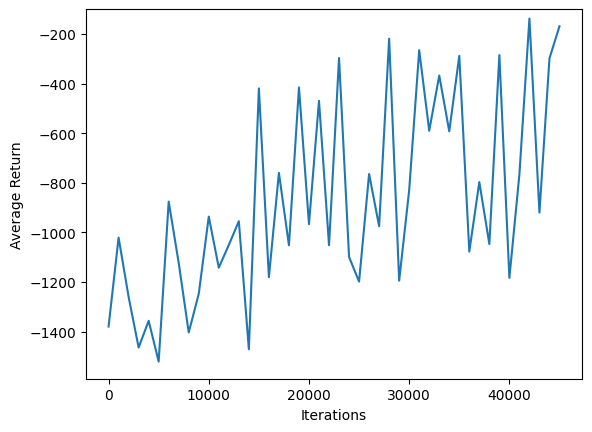

In [69]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=-100)

#Video<br>
To get a video we must create a function to embed videos in the notebook.

In [70]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the `Pendulum` game with the agent. The underlying Python environment (the one "inside: the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video

In [71]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

In [72]:
create_policy_eval_video(random_policy, "random-agent")